In [8]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
import igraph as ig
from gurobipy import GRB
from numba import jit

plt.style.use('default')                                    # 使用默认风格
plt.rcParams['figure.facecolor'] = 'white'                  # 将图形的背景颜色设置为白色
plt.rcParams['font.family'] = 'YaHei Consolas Hybrid'       # 字体确认
plt.rcParams['font.size'] = 12                              # 字体大小
plt.rcParams['axes.unicode_minus'] = False                  # 正常显示负号
%matplotlib inline


### 参数设置

In [9]:
# 点总数
nodecnts = 130
# 喷水车数目
carcnts = 20
# 名称--点序号
node_number = {}
# 点序号--坐标
num2pos = {}
# 边的信息
edgeInfo = np.zeros((nodecnts, nodecnts))
# 停靠点数目
stopNodes = 2
# 工作点数目
workingNodes = 0
working_map = {}
# 给水点数目
waterNodes = 0
water_map = {}
# 正常点的数目
normalNodes = 0
normal_map = {}
# A车、B车在1级路的速度
speed1 = (60, 50)
# A车、B车在2级路的速度       
speed2 = (45, 30)
# A车、B车的作业时间
workingcost = (1/3, 1/4)
# 构建花费矩阵
# fullcostmat[0][][]是A车的时间花费矩阵,fullcostmat[1][][]是B车的
fullcostmat = np.zeros((2, nodecnts, nodecnts))
# 0--D1  1--D2
car_start = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
# 0--A  1--B
car_category = np.array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1])

### 数据处理

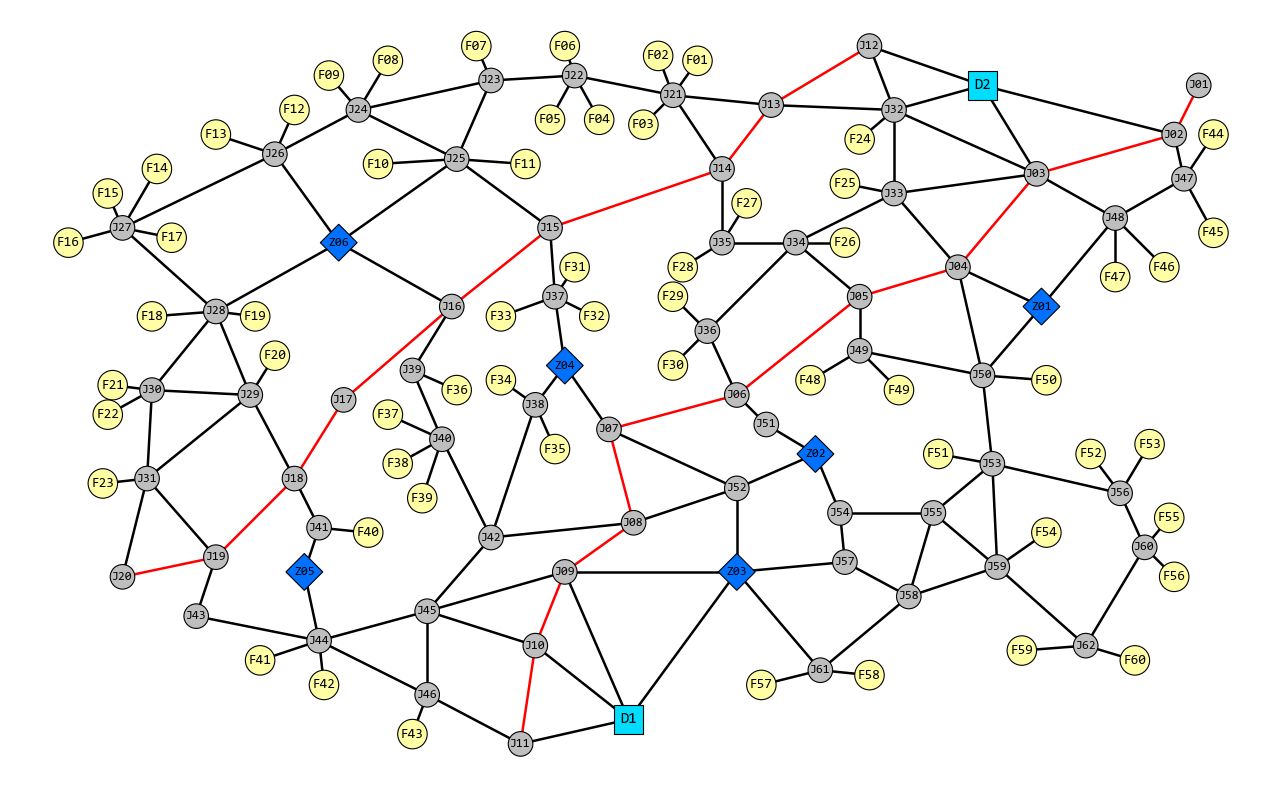

In [10]:
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
def dis(p1: Point, p2: Point):
    return ((p2.x - p1.x)**2 + (p2.y - p1.y)**2)**0.5

with open('节点信息.txt','r') as file:
    for line in file:
        line = line.strip()
        if line:
            node_data = line.split('\t')
            node_name = node_data[0]
            x = float(node_data[1])
            y = float(node_data[2])
            num = int(node_data[3])
            p = Point(x, y)
            node_number[node_name] = num
            node_number[num] = node_name
            num2pos[num] = p
            # 按照点的分类，给每一类点的重新编号对应着原始的编号
            if node_name[0] == 'Z':
                water_map[waterNodes] = num
                waterNodes += 1
            elif node_name[0] == 'F':
                working_map[workingNodes] = num
                workingNodes += 1
            elif node_name[0] == 'J':
                normal_map[normalNodes] = num
                normalNodes += 1

# 添加两个额外点作为终点和对应的映射
node_number[nodecnts] = 'D1'
node_number[nodecnts + 1] = 'D2'

            
with open('连通情况.txt','r') as file:
    for line in file:
        line = line.strip()
        if line:
            edge_data = line.split(' ')
            N1 = node_number[edge_data[0]]
            N2 = node_number[edge_data[1]]
            edgeInfo[N1][N2] = edgeInfo[N2][N1] = edge_data[2]

# 构建花费矩阵
# 计算A、B车时间花费矩阵
for c in range(2):
    for i in range(nodecnts):
        for j in range(nodecnts):
            if edgeInfo[i][j] == 0:
                fullcostmat[c][i][j] = np.inf
            elif edgeInfo[i][j] == 1:
                d = dis(num2pos[i], num2pos[j])
                fullcostmat[c][i][j] = d / speed1[c]
            elif edgeInfo[i][j] == 2:
                d = dis(num2pos[i], num2pos[j])
                fullcostmat[c][i][j] = d / speed2[c]

# 最短路与矩阵切割

@jit(nopython=True)
def Floyd(costmat):
    # Floyd跑一波得到点到点的最短路
    for c in range(2):
        for k in range(nodecnts):
            for i in range(nodecnts):
                for j in range(nodecnts):
                    if i == j:
                        continue
                    costmat[c][i][j] = min(costmat[c][i][j], 
                        costmat[c][i][k] + costmat[c][k][j]
                        )
    return costmat

fullcostmat = Floyd(fullcostmat)

# 取前2 + 6 + 60 + 2个点即停靠点+给水点+作业点+两个虚拟的停靠点作为终点
costmat = fullcostmat[::, :70, :70]

for i in range(2):
    # 前两列复制到后两列
    costmat[i][:, -2:] = costmat[i][:, :2]
    # 前两行复制到后两行
    costmat[i][-2:, :] = costmat[i][:2, :]
    

# 绘图

def draw_graph():
    g = ig.Graph()

    # 添加点
    g.add_vertices(nodecnts)
    g.vs["x"] = [num2pos[i].x for i in range(nodecnts)]
    g.vs["y"] = [num2pos[i].y for i in range(nodecnts)]
    g.vs["label"] = [node_number[i] for i in range(nodecnts)]
    g.vs["label_size"] = [9 if node_number[i][0] == "Z" else
                    10 if node_number[i][0] == "F" else
                    9 if node_number[i][0] == "J" else
                    11 for i in range(nodecnts)]
    g.vs["size"] = [7.5 if node_number[i][0] == "Z" else
                    6 if node_number[i][0] == "F" else
                    5 if node_number[i][0] == "J" else
                    6 for i in range(nodecnts)]
    g.vs["color"] = ["#0070FF" if node_number[i][0] == "Z" else
                    "#FFFEA4" if node_number[i][0] == "F" else
                    "gray" if node_number[i][0] == "J" else
                    "#00DDFF" for i in range(nodecnts)]
    g.vs["shape"] = ["diamond" if node_number[i][0] == "Z" else
                    "circle" if node_number[i][0] == "F" else
                    "circle" if node_number[i][0] == "J" else
                    "rectangle" for i in range(nodecnts)]

    # 添加边
    # 根据costmat[0]添加边（只添加单条边）
    for i in range(nodecnts):
        for j in range(i+1, nodecnts):
            if edgeInfo[i][j] == 1:
                g.add_edge(i, j, weight=fullcostmat[0][i][j], color="red")
            elif edgeInfo[i][j] == 2:
                g.add_edge(i, j, weight=fullcostmat[0][i][j], color="black")
    return g
                
g = draw_graph()
fig, ax = plt.subplots(figsize=(40, 10))
ig.plot(g, target=ax, layout=g.layout_auto(), edge_width=1.8, vertex_frame_width=0.8)
plt.show()

In [24]:
## 第一问线性规划

# 创建优化问题
prob1 = gp.Model('喷洒车作业优化Q1')
# 创建优化变量
x = prob1.addVars(carcnts, workingNodes, waterNodes, vtype=GRB.BINARY, name='working_path')
t = prob1.addVars(carcnts, vtype=GRB.CONTINUOUS, name='cost') 
tmax = prob1.addVar(vtype=GRB.CONTINUOUS, name='maxcost')

# 每个喷洒车只能作业一次
for i in range(carcnts):
    prob1.addConstr(gp.quicksum(x[i, j, k] for j in range(workingNodes) for k in range(waterNodes)) == 1)

# 每个作业点最多作业1次
for j in range(workingNodes):
    prob1.addConstr(gp.quicksum(x[i, j, k] for i in range(carcnts) for k in range(waterNodes)) <= 1)
    
# 单个给水点最多加8次水
for k in range(waterNodes):
    prob1.addConstr(gp.quicksum(x[i, j, k] for i in range(carcnts) for j in range(workingNodes)) <= 8)
    
# 计算每一个洒水车的用时
for i in range(carcnts):
    cg = car_category[i]
    startPoint = car_start[i]
    expr = gp.LinExpr()
    for j in range(workingNodes):
        for k in range(waterNodes):
            new_j = working_map[j]
            new_k = water_map[k]
            expr += x[i, j, k] * (costmat[cg][startPoint][new_j] + costmat[cg][new_j][new_k] + workingcost[cg]) 
            
    prob1.addConstr(t[i] == expr)

# 求最长用时的车
prob1.addConstr(tmax == gp.max_(t[i] for i in range(carcnts)))

# 目标函数
prob1.setObjectiveN(tmax, priority=1, index=0)
prob1.setObjectiveN(t.sum(), priority=0, index=1)
#prob1.write("ModelQ1.lp")
prob1.update()
prob1.optimize()


Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 106 rows, 7221 columns and 28820 nonzeros
Model fingerprint: 0x90e182cc
Model has 1 general constraint
Variable types: 21 continuous, 7200 integer (7200 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+00]

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 2 objectives ... 
---------------------------------------------------------------------------

Multi-objectives: applying initial presolve ...
---------------------------------------------------------------------------

Presolve added 41 rows and 40 columns
Presolve time: 0.08s
Presolved: 147 rows and 7261 columns

In [39]:
## 第一问输出
Q1workingnodeLst = []
# 绘制图形
q1g = draw_graph()

print(f"任务完成用时：{round(tmax.x, 2)} h")
for i in range(carcnts):
    for j in range(workingNodes):
        for k in range(waterNodes):
            if x[i, j, k].x:
                category = car_category[i]
                startPoint = car_start[i]
                new_j = working_map[j]
                new_k = water_map[k]
                path1 = g.get_shortest_paths(startPoint, new_j, weights="weight")[0]
                path1_node = [node_number[num] for num in path1]
                path2 = g.get_shortest_paths(new_j, new_k, weights="weight")[0]
                path2_node = [node_number[num] for num in path2]
                
                q1g.vs[new_j]["label"] = f"{'A' if category == 0 else 'B'}{i}"
                q1g.vs[new_j]["color"] = "#F18A7C"
                
                path1_node[0] += "(起点)"
                path2_node[0] += "(作业点)"
                path2_node[-1] += "(给水点)"
                points = path1_node[:-1] + path2_node
                output = "--".join(points)
                print(f"编号：{'A' if category == 0 else 'B'}{i}\t用时：{round(t[i].x, 2)}h\t路线：{output}")

fig1, ax1 = plt.subplots(figsize=(40, 10))
ig.plot(q1g, target=ax1, layout=q1g.layout_auto(), edge_width=1.8, vertex_frame_width=0.8)
plt.savefig('Q1res.png', dpi=300, bbox_inches='tight', format='png')
plt.show()

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 238 rows, 64821 columns and 259220 nonzeros
Model fingerprint: 0x13dd4a11
Model has 1 general constraint
Variable types: 21 continuous, 64800 integer (64800 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+00]

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 2 objectives ... 
---------------------------------------------------------------------------

Multi-objectives: applying initial presolve ...
---------------------------------------------------------------------------

Presolve added 41 rows and 40 columns
Presolve time: 0.65s
Presolved: 279 rows and 64861 co

AttributeError: 'gurobipy.Var' object has no attribute 'x'

In [11]:
## 第二问线性规划

# 创建优化问题
prob2 = gp.Model('喷洒车作业优化Q2')
# 创建优化变量
x1 = prob2.addVars(carcnts, workingNodes, waterNodes, vtype=GRB.BINARY, name='workingState1')
x2 = prob2.addVars(carcnts, waterNodes, workingNodes, waterNodes, vtype=GRB.BINARY, name='workingState2')
t = prob2.addVars(carcnts, vtype=GRB.CONTINUOUS, name='cost') 
tmax = prob2.addVar(vtype=GRB.CONTINUOUS, name='maxcost')

# 每个喷洒车必须作业两次
for i in range(carcnts):
    prob2.addConstr(gp.quicksum(x1[i, j1, k1] 
                                for j1 in range(workingNodes) for k1 in range(waterNodes)) == 1)
    prob2.addConstr(gp.quicksum(x2[i, k1, j2, k2] 
                                for k1 in range(waterNodes) for j2 in range(workingNodes) for k2 in range(waterNodes)) == 1)
    for k1 in range(waterNodes):
        prob2.addConstr(gp.quicksum(x1[i, j1, k1] for j1 in range(workingNodes)) == 
                        gp.quicksum(x2[i, k1, j2, k2] for j2 in range(workingNodes) for k2 in range(waterNodes)))

# 每个作业点最多作业1次
for j in range(workingNodes):
    prob2.addConstr(gp.quicksum(x1[i, j, k1] for i in range(carcnts) for k1 in range(waterNodes)) + 
                    gp.quicksum(x2[i, k1, j, k2] 
                                for i in range(carcnts) for k1 in range(waterNodes) for k2 in range(waterNodes)) <= 1)
    
# 单个给水点最多加8次水
for k in range(waterNodes):
    prob2.addConstr(gp.quicksum((x2[i, k, j, kk] + x2[i, kk, j, k]) 
                                for i in range(carcnts) for j in range(workingNodes) for kk in range(waterNodes)) <= 8)
    
# 计算每一个洒水车的用时
for i in range(carcnts):
    # 对于每一辆车
    cg = car_category[i]
    sp = car_start[i]
    # 第一阶段耗时
    expr1 = gp.quicksum(x1[i, j1, k1] * 
                        (costmat[cg][sp][working_map[j1]] + costmat[cg][working_map[j1]][water_map[k1]] + workingcost[cg]) 
                        for j1 in range(workingNodes) for k1 in range(waterNodes))
    # 第二阶段耗时
    expr2 = gp.quicksum(x2[i, k1, j2, k2] * 
                        (costmat[cg][water_map[k1]][working_map[j2]] + costmat[cg][working_map[j2]][water_map[k2]] + workingcost[cg]) 
                        for k1 in range(waterNodes) for j2 in range(workingNodes) for k2 in range(waterNodes))
    
    prob2.addConstr(t[i] == expr1 + expr2)

# 求最长用时的车
prob2.addConstrs(tmax >= t[i] for i in range(carcnts))

# 目标函数
prob2.setObjectiveN(tmax, priority=1, index=0)
prob2.setObjectiveN(t.sum(), priority=0, index=1)

# 求解参数
prob2.Params.MIPFocus=0
prob2.Params.Presolve=2

prob2.update()
prob2.write("ModelQ2.lp")
prob2.optimize()

Set parameter Presolve to value 2
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 266 rows, 50421 columns and 280860 nonzeros
Model fingerprint: 0x33c3a49c
Variable types: 21 continuous, 50400 integer (50400 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+00]

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 2 objectives ... 
---------------------------------------------------------------------------

Multi-objectives: applying initial presolve ...
---------------------------------------------------------------------------

Presolve time: 1.01s
Presolved: 266 rows and 50421 columns
-----------------------------

任务完成用时：6.69 h
编号：A-0	用时：6.5h	路线：D1--Z03--J57--J54--J55--J53--F51(作业点)--J53--J55--J54--Z02(给水点)--J51--J06--J36--F30(作业点)--J36--J06--J51--Z02(给水点)
编号：A-1	用时：6.67h	路线：D1--J10--J45--J42--J40--F38(作业点)--J40--J39--J16--Z06(给水点)--J28--F19(作业点)--J28--J29--J18--J41--Z05(给水点)
编号：A-2	用时：5.78h	路线：D1--J10--J45--J42--J40--J39--F36(作业点)--J39--J16--Z06(给水点)--J26--F12(作业点)--J26--Z06(给水点)
编号：A-3	用时：6.59h	路线：D1--Z03--J61--F58(作业点)--J61--Z03(给水点)--J52--Z02--J51--J06--J05--J49--F48(作业点)--J49--J50--Z01(给水点)
编号：A-4	用时：6.08h	路线：D1--Z03--J61--F57(作业点)--J61--Z03(给水点)--J57--J58--J59--F54(作业点)--J59--J55--J54--Z02(给水点)
编号：A-5	用时：6.01h	路线：D1--J10--J45--J42--J40--F37(作业点)--J40--J39--J16--Z06(给水点)--J26--F13(作业点)--J26--Z06(给水点)
编号：B-6	用时：5.82h	路线：D1--J09--J08--J07--Z04--J37--F33(作业点)--J37--Z04(给水点)--J38--F34(作业点)--J38--Z04(给水点)
编号：B-7	用时：5.82h	路线：D1--J09--J08--J07--Z04--J37--F31(作业点)--J37--Z04(给水点)--J37--F32(作业点)--J37--Z04(给水点)
编号：B-8	用时：5.14h	路线：D1--J11--J46--F43(作业点)--J46--J44--Z05(给水点)--J41--F40(作业点)--J41--Z05(给水点)

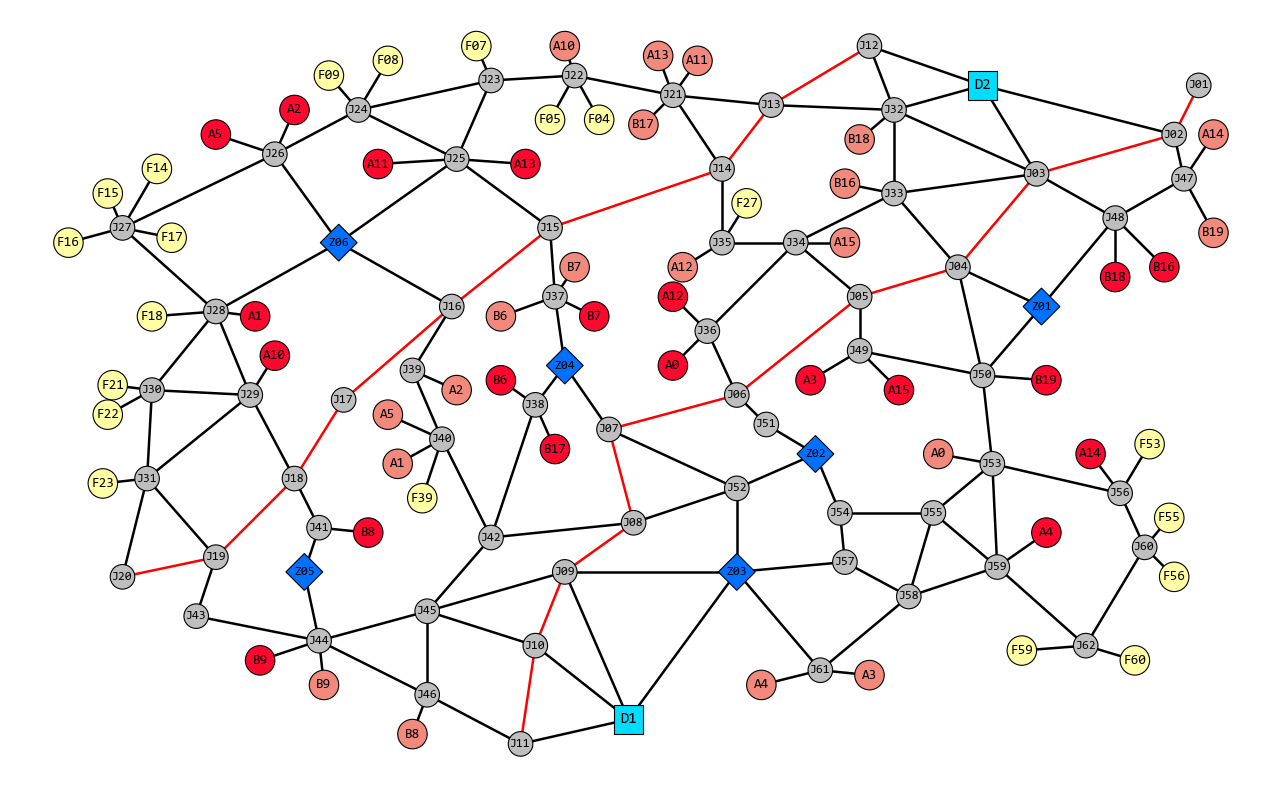

In [13]:
## 第二问输出
Q1workingnodeLst = []
Q2workingnodeLst = []
Zcnt = [0,0,0,0,0,0]
# 绘制图形
q2g = draw_graph()

print(f"任务完成用时：{round(tmax.x, 2)} h")
for i in range(carcnts):
    for j1 in range(workingNodes):
        for k1 in range(waterNodes):
            if x1[i, j1, k1].x:
                for j2 in range(workingNodes):
                    for k2 in range(waterNodes):
                            if x2[i, k1, j2, k2].x:
                                Zcnt[k1] += 1
                                Zcnt[k2] += 1
                                category = car_category[i]
                                startPoint = car_start[i]
                                new_j1 = working_map[j1]; new_j2 = working_map[j2]
                                new_k1 = water_map[k1]; new_k2 = water_map[k2]
                                path1 = g.get_shortest_paths(startPoint, new_j1, weights="weight")[0]
                                path1_node = [node_number[num] for num in path1]
                                path2 = g.get_shortest_paths(new_j1, new_k1, weights="weight")[0]
                                path2_node = [node_number[num] for num in path2]
                                
                                q2g.vs[new_j1]["label"] = f"{'A' if category == 0 else 'B'}{i}"
                                q2g.vs[new_j1]["color"] = "#F18A7C"
                                
                                #path1_node[0] += "(起点)"
                                path2_node[0] += "(作业点)"
                                path2_node[-1] += "(给水点)"
                                points = path1_node[:-1] + path2_node
                                
                                path3 = g.get_shortest_paths(new_k1, new_j2, weights="weight")[0]
                                path3_node = [node_number[num] for num in path3]
                                path4 = g.get_shortest_paths(new_j2, new_k2, weights="weight")[0]
                                path4_node = [node_number[num] for num in path4]
                                
                                q2g.vs[new_j2]["label"] = f"{'A' if category == 0 else 'B'}{i}"
                                q2g.vs[new_j2]["color"] = "#FD082F"
                                
                                path4_node[0] += "(作业点)"
                                path4_node[-1] += "(给水点)"
                                points += path3_node[1:-1] + path4_node
                                
                                output = "--".join(points)
                                print(f"编号：{'A' if category == 0 else 'B'}-{i}\t用时：{round(t[i].x, 2)}h\t路线：{output}")
                                
                                # 更改节点名称
                                
                   
for k in range(waterNodes):
    print(f"{node_number[water_map[k]]}使用次数：{Zcnt[k]}")
                        

fig2, ax2 = plt.subplots(figsize=(40, 10))
ig.plot(q2g, target=ax2, layout=q2g.layout_auto(), edge_width=1.8, vertex_frame_width=0.8)
plt.savefig('Q2res.png', dpi=300, bbox_inches='tight', format='png')
plt.show()


In [4]:
## 第三问线性规划模型建立(old)
N = costmat[0].shape[0]
# 车辆序号集合
I = list(range(carcnts))
# 车辆终止点
car_end = car_start + N - 2
# 起始停靠点集合
Sb = list(range(2))
# 返回停靠点集合(虚拟点)
Se = [N - 2, N - 1]
# 工作点集合
F = [i for i in range(nodecnts) if node_number[i][0]=='F']
# 给水点集合
Z = [i for i in range(nodecnts) if node_number[i][0]=='Z']

# 创建优化问题
prob3 = gp.Model('喷洒车作业优化Q3')
# 创建优化变量
x3 = prob3.addVars(carcnts, len(Sb+Z+F+Se), len(Sb+Z+F+Se), vtype=GRB.BINARY, name='workingMat')
# u表示各点的经过顺序个数为：1个起点+给水点个数
u = prob3.addVars(carcnts, len(Sb+Z+F+Se), vtype=GRB.INTEGER, name='order')
n = prob3.addVars(carcnts, lb=1, ub=5, vtype=GRB.INTEGER, name='workingTimes')
t = prob3.addVars(carcnts, vtype=GRB.CONTINUOUS, name='cost') 
tmax = prob3.addVar(1, vtype=GRB.CONTINUOUS, name='maxcost')

## 去除不可能路径
for i in I:
    # 以下注释的路线均不存在

    # 实起点到起点、起点到给水点、起点到终点
    # 给水点到起点、给水点到给水点、给水点到终点
    prob3.addConstr(gp.quicksum(x3[i, j, k] for j in (Sb + Z) for k in (Sb + Z + Se)) == 0)
    # 作业点到起点、作业点到作业点
    prob3.addConstr(gp.quicksum(x3[i, j, k] for j in F for k in (Sb + F)) == 0)
    # 终点到所有其他地方
    prob3.addConstr(gp.quicksum(x3[i, j, k] for j in Se for k in (Sb + Z + F + Se)) == 0)
    
## 每辆车的作业量总和为工作点的数目
prob3.addConstr(gp.quicksum(n[i] for i in I) == len(F))

## 对于每一辆车的作业情况
for i in I:
    # 从起点到第一个作业点只能有唯一一条路
    prob3.addConstr(gp.quicksum(x3[i, j, k] for j in Sb for k in F) == 1)
    # 根据车型进行进一步指定
    sp = car_start[i]
    prob3.addConstr(gp.quicksum(x3[i, sp, k] for k in F) == 1)
    
    # 从最后工作点返回终点只能有唯一一条路
    prob3.addConstr(gp.quicksum(x3[i, j, k] for j in F for k in Se) == 1)
    # 根据车型进行进一步指定
    ep = car_end[i]
    prob3.addConstr(gp.quicksum(x3[i, j, ep] for j in F) == 1)
    
    # 第i辆车进行ni次作业，那么从给水点到工作点的次数为ni - 1
    prob3.addConstr(gp.quicksum(x3[i, j, k] for j in Z for k in F) == n[i] - 1)
    
    # 同理，从工作点到给水点的次数为ni - 1
    prob3.addConstr(gp.quicksum(x3[i, j, k] for j in F for k in Z) == n[i] - 1)
    
    
## 每一个工作点必须作业一次
for k in F:
    prob3.addConstr(gp.quicksum(x3[i, j, k] for i in I for j in (Sb + Z)) == 1)
# # 冗余添加
# for j in F:
#     prob3.addConstr(gp.quicksum(x3[i, j, k] for i in I for k in (Z + Se)) == 1)

## 给水点最多加8次水
for k in Z:
    prob3.addConstr(gp.quicksum(x3[i, j, k] for i in I for j in F) <= 8)
# # 冗余添加
# for j in Z:
#     prob3.addConstr(gp.quicksum(x3[i, j, k] for i in I for k in F) <= 8)

## 保证喷洒车每一步的连续性(上一步的终点就是这一步的起点)
# 连续性相当于流量平衡
# 作业点的连续性
for i in I:
    for f in F:
        prob3.addConstr(gp.quicksum(x3[i, f, k] for k in (Z + Se)) == gp.quicksum(x3[i, j, f] for j in (Sb + Z)))
# 给水站的连续性
for i in I:
    for z in Z:
        prob3.addConstr(gp.quicksum(x3[i, j, z] for j in F) == gp.quicksum(x3[i, z, k] for k in F))
    
## 计算每辆车耗费的时间
for i in I:
    cg = car_category[i]
    # 总时间 = 从起点或者给水站到工作点和时间和 + 从工作点到给水站或终点的时间和 + 该车作业次数 * 该车单次作业时间
    prob3.addConstr(t[i] == gp.quicksum(costmat[cg][j][k] * x3[i, j, k] for j in (Sb + Z) for k in F) + 
                    gp.quicksum(costmat[cg][j][k] * x3[i, j, k] for j in F for k in (Z + Se)) + 
                    n[i] * workingcost[cg])
    
## 最大时间约束
prob3.addConstrs(tmax >= t[i] for i in I)

## 目标函数
prob3.setObjectiveN(tmax, priority=1, index=0)
prob3.setObjectiveN(t.sum(), priority=0, index=1)



In [11]:
## 第三问线性规划模型改良
N = costmat[0].shape[0]
# 车辆序号集合
I = list(range(carcnts))
# 车辆终止点
car_end = car_start + N - 2
# 起始停靠点集合
Sb = list(range(2))
# 返回停靠点集合(虚拟点)
Se = [N - 2, N - 1]
# 工作点集合
F = [i for i in range(nodecnts) if node_number[i][0]=='F']
# 给水点集合
Z = [i for i in range(nodecnts) if node_number[i][0]=='Z']

# 创建优化问题
prob3 = gp.Model('喷洒车作业优化Q3')
# 创建优化变量
x3 = prob3.addVars(carcnts, len(Sb+Z+F+Se), len(Sb+Z+F+Se), vtype=GRB.BINARY, name='edgeMat')
fcho = prob3.addVars(carcnts, len(F), vtype=GRB.BINARY, name='workingNodes')
zcho = prob3.addVars(carcnts, len(Z), vtype=GRB.INTEGER, name='waterNodes')
# u表示各点的经过顺序个数为：1个起点+给水点个数
u = prob3.addVars(carcnts, len(Sb+Z+F+Se), vtype=GRB.INTEGER, name='order')
t = prob3.addVars(carcnts, vtype=GRB.CONTINUOUS, name='cost') 
tmax = prob3.addVar(1, vtype=GRB.CONTINUOUS, name='maxcost')

## 去除不可能路径           1
for i in I:
    # 以下注释的路线均不存在

    # 实起点到起点、起点到给水点、起点到终点
    # 给水点到起点、给水点到给水点、给水点到终点
    prob3.addConstr(gp.quicksum(x3[i, j, k] for j in (Sb + Z) for k in (Sb + Z + Se)) == 0)
    # 作业点到起点、作业点到作业点
    prob3.addConstr(gp.quicksum(x3[i, j, k] for j in F for k in (Sb + F)) == 0)
    # 终点到所有其他地方
    prob3.addConstr(gp.quicksum(x3[i, j, k] for j in Se for k in (Sb + Z + F + Se)) == 0)

## 对于每一辆车的作业情况               6
for i in I:
    sp = car_start[i]
    if sp == 0:
        other_sp = 1
    else:
        other_sp = 0
    # 从起点到第一个作业点只能有唯一一条路
    prob3.addConstr(gp.quicksum(x3[i, sp, k] for k in F) == 1)
    prob3.addConstr(gp.quicksum(x3[i, other_sp, k] for k in F) == 0)
    
    ep = car_end[i]
    if ep == 68:
        other_ep = 69
    else:
        other_ep = 68
    # 从起点到第一个作业点只能有唯一一条路
    prob3.addConstr(gp.quicksum(x3[i, j, ep] for j in F) == 1)
    prob3.addConstr(gp.quicksum(x3[i, j, other_ep] for j in F) == 0)

## fcho和zcho满足一定的数量关系，即加水次数等作业次数-1     4
for i in I:
    prob3.addConstr(gp.quicksum(zcho[i, j] for j in range(waterNodes))
                    == gp.quicksum(fcho[i, j] for j in range(workingNodes)) - 1)
    
## 引入假设，所有车的作业次数不超过4次
for i in I:
    prob3.addConstr(gp.quicksum(fcho[i, j] for j in range(workingNodes)) <= 5)

## 每一个工作点必须作业一次             2
for j in range(workingNodes):
    prob3.addConstr(gp.quicksum(fcho[i, j] for i in I) == 1)

## 给水点最多加8次水                    3
for k in range(waterNodes):
    prob3.addConstr(gp.quicksum(zcho[i, k] for i in I) <= 8)

## 使用01向量fcho来约束工作的点     5
for i in I:
    for f in range(workingNodes):
        new_f = working_map[f]
        # 对于从其他点(起点或者给水点)到工作点的约束
        prob3.addConstr(gp.quicksum(x3[i, j, new_f] for j in (Sb + Z)) == fcho[i, f])
        # 对于工作点到其他点(给水点或者终点)的约束
        prob3.addConstr(gp.quicksum(x3[i, new_f, k] for k in (Z + Se)) == fcho[i, f])

## 使用01向量zcho来约束给水点      5
for i in I:
    for z in range(waterNodes):
        new_z = water_map[z]
        prob3.addConstr(gp.quicksum(x3[i, j, new_z] for j in F) == zcho[i, z])
        prob3.addConstr(gp.quicksum(x3[i, new_z, k] for k in F) == zcho[i, z])

# MTZ约束条件避免出现子环           7
for i in I:
    # 起点的循序都设为0
    prob3.addConstr(u[i, 0] == 0)
    prob3.addConstr(u[i, 1] == 0)
    
    # 起点到第一个作业点约束
    prob3.addConstrs(u[i, j] - u[i, k] + N * x3[i, j, k] <= N - 1 for j in Sb for k in F)
    # 作业点到给水点约束
    prob3.addConstrs(u[i, j] - u[i, k] + N * x3[i, j, k] <= N - 1 for j in F for k in Z)
    # 给水点到作业点约束
    prob3.addConstrs(u[i, j] - u[i, k] + N * x3[i, j, k] <= N - 1 for j in Z for k in F)
    # 作业点到终点约束
    prob3.addConstrs(u[i, j] - u[i, k] + N * x3[i, j, k] <= N - 1 for j in F for k in Se)

## 计算每辆车耗费的时间         8
for i in I:
    cg = car_category[i]
    # 总时间 = 从起点或者给水站到工作点和时间和 + 从工作点到给水站或终点的时间和 + 该车作业次数 * 该车单次作业时间
    prob3.addConstr(t[i] == gp.quicksum(costmat[cg][j][k] * x3[i, j, k] for j in (Sb + Z) for k in F) + 
                    gp.quicksum(costmat[cg][j][k] * x3[i, j, k] for j in F for k in (Z + Se)) + 
                    gp.quicksum(fcho[i, j] for j in range(workingNodes)) * workingcost[cg])
    
## 最大时间约束             9
prob3.addConstrs(tmax >= t[i] for i in I)

## 目标函数
prob3.setObjectiveN(tmax, priority=1, index=0)
prob3.setObjectiveN(t.sum(), priority=0, index=1)

prob3.write("ModelQ3.lp")

In [5]:
# Lazycon方法动态添加约束避免出现子环

# 定义callback回调函数
def cbFcn(model, where):
    # 触发事件：MIP找到了可行解
    if where == GRB.Callback.MIPSOL:
        # 对于每一辆车的可行解，找到一个最短的子环，并为其添加len(I)个约束
        x = model.cbGetSolution(model._x)
        
        # st = time.time()
        
        # fulledges = gp.tuplelist((j, k) for i, j, k in x.keys()
        #             if x[i, j, k] > 0.5)
        # edges = []
        # cur_edges = []
        # last_num = -np.inf
        # for edge in fulledges:
        #     cur_num = edge[0]
        #     if cur_num >= last_num:
        #         cur_edges.append(edge)
        #     else:
        #         edges.append(cur_edges)
        #         cur_edges = [edge]
            
        #     last_num = cur_num
        # edges.append(cur_edges)
        
        for i in model._I:
            tours = getMintour(x, i, model._N)
            for tour in tours:
                if len(tour) < model._N:
                    # 如果最小环是一个子环
                    # 添加一个DFJ约束：子集合边数 <= 点数 - 1
                    model.cbLazy(gp.quicksum(model._x[i, j, k] for j in tour for k in tour) <= 
                                len(tour) - 1)
        # mintour = getMintour(edges, model._I)
        # for i in model._I:
        #     if len(mintour[i]) < model._N:
        #         # 如果最小环是一个子环
        #         # 添加一个DFJ约束：子集合边数 <= 点数 - 1
        #         model.cbLazy(gp.quicksum(model._x[i, j, k] for j in mintour[i] for k in mintour[i]) <= 
        #                      len(mintour[i]) - 1)
        
        # et = time.time()
        # print(f"回调函数耗时{et - st}")

def getMintour(x, i, n):
    # x是有向邻接矩阵，这里生成无向边
    # 获取正边
    edges = gp.tuplelist((j, k) for j in range(n) for k in range(n)
                         if j != k and x[i, j, k] > 0.5)
    unvisited = set()
    for j, k in edges:
        unvisited.add(j)
        unvisited.add(k)
    unvisited = list(unvisited)
    cycle = []
    while unvisited:
        curcycle = []
        neighbors = unvisited
        while neighbors:
            current = neighbors[0]
            curcycle.append(current)
            unvisited.remove(current)
            neighbors = [j for i, j in edges.select(current, '*')
                         if j in unvisited]
        
        cycle.append(curcycle)
    return cycle

# #@jit()
# def getMintour(edges, I):
#     ## 一口气求完所有车辆的最小环
#     mintour = list(range(I))
#     for i in I:
#         mintourLen = np.inf
#         # 创建邻接表
#         adj_list = {}
#         unvisited = set()
#         for j, k in edges[i]:
#             adj_list[j] = k
#             unvisited.add(j)
#             unvisited.add(k)
#         unvisited = list(unvisited)
#         # 找最小换代码参考自gurobi样例tsp.py
#         while unvisited:
#             curcycle = []
#             neighbors = unvisited[0]
#             while True:
#                 current = neighbors
#                 curcycle.append(current)
#                 unvisited.remove(current)
#                 neighbors = adj_list.get(current, -1)
#                 if neighbors == -1 or neighbors not in unvisited:
#                     break
#             if mintourLen > len(curcycle) and len(curcycle) > 1:
#                 mintourLen = len(curcycle)
#                 mintour[i] = curcycle       
#     return mintour


# 求解参数
prob3.Params.NoRelHeurTime = 60 * 50
prob3.Params.MIPGap = 0.01
prob3.Params.TimeLimit = 60 * 60
prob3.Params.lazyConstraints = 1

# 将各种变量放到模型中方便参数传递
prob3._x = x3
prob3._I = I
prob3._N = N

# 将回调函数应用到优化器中
prob3.optimize(cbFcn)

Set parameter NoRelHeurTime to value 3000
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 3600
Set parameter LazyConstraints to value 1
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 2926 rows, 100741 columns and 144140 nonzeros
Model fingerprint: 0x29968ca8
Variable types: 21 continuous, 100720 integer (99200 binary)
Coefficient statistics:
  Matrix range     [3e-01, 7e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+00]
Presolve removed 114 rows and 81194 columns
Presolve time: 0.15s
Presolved: 2812 rows, 19547 columns, 55732 nonzeros
Variable types: 7 continuous, 19540 integer (18000 binary)
Starting NoRel heuristic
Found phase-1 solution: relaxation 14
Found phase-1 solution: relaxation 13
Found phase-1 solution: rela

Read LP format model from file ModelQ3.lp
Reading time = 0.19 seconds
: 22166 rows, 100741 columns, 201780 nonzeros
任务耗时：12.478
A0，耗时：12.451 D1--F35--Z04--F11--Z06--F15--Z05--F40--D1
A1，耗时：12.405 D1--F42--Z05--F18--Z06--F10--Z04--F38--D1
A2，耗时：12.45 D1--F41--Z05--F14--Z06--F17--D1
A3，耗时：12.424 D1--F57--Z03--F53--Z01--F60--D1
A4，耗时：12.475 D1--F23--Z05--F21--Z06--F19--D1
A5，耗时：12.144 D1--F30--Z02--F59--Z03--F54--D1
B6，耗时：12.233 D1--F27--Z02--F29--D1
B7，耗时：12.171 D1--F37--Z04--F39--D1
B8，耗时：12.452 D1--F43--Z05--F36--Z04--F34--D1
B9，耗时：11.959 D1--F31--Z04--F33--Z03--F58--D1
A10，耗时：12.215 D2--F25--Z01--F56--Z02--F05--D2
A11，耗时：12.252 D2--F20--Z05--F22--Z06--F07--D2
A12，耗时：12.439 D2--F02--Z04--F32--Z02--F52--Z01--F47--D2
A13，耗时：11.634 D2--F01--Z02--F55--Z01--F45--D2
A14，耗时：12.445 D2--F09--Z06--F08--Z04--F04--D2
A15，耗时：12.478 D2--F06--Z06--F16--Z04--F03--D2
B16，耗时：12.474 D2--F44--Z01--F50--Z02--F49--D2
B17，耗时：12.44 D2--F48--Z02--F26--Z01--F24--D2
B18，耗时：12.455 D2--F46--Z01--F51--Z02--F28--D2


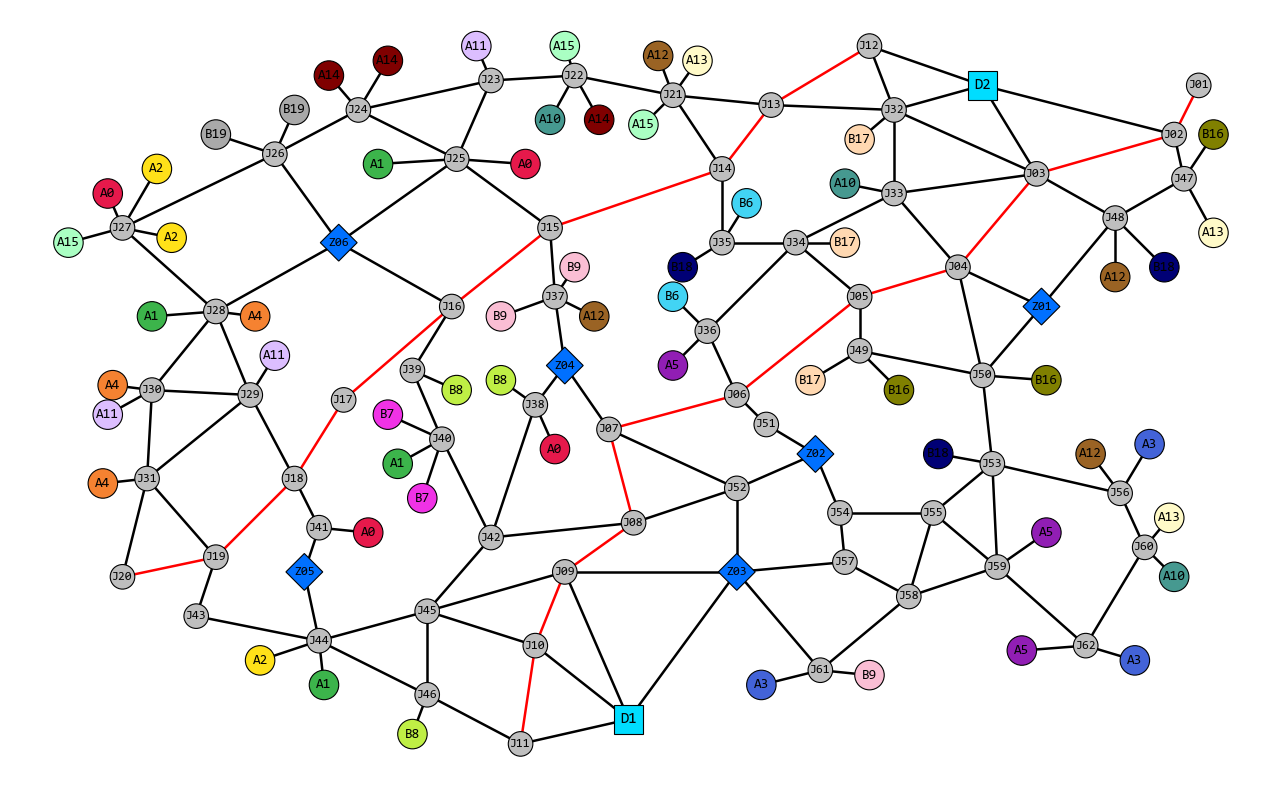

In [31]:
def find_cycle_points(A, start_point):
    # 记录已访问的节点
    visited = set()
    # 存储结果的列表
    cycle_points = []

    # 深度优先搜索
    def dfs(node):
        visited.add(node)
        cycle_points.append(node)

        for next_node in range(len(A[node])):
            if next_node not in visited and A[node][next_node] > 0.5:
                dfs(next_node)

    # 从起点开始搜索
    dfs(start_point)

    return cycle_points

# 读取模型和解
model = gp.read('ModelQ3.lp')
model.read('ModelQ3 obj 12.4784.sol')

edgeMat = np.zeros((carcnts, len(Sb+Z+F+Se), len(Sb+Z+F+Se)))
maxcost = 0
cost = np.zeros((carcnts,))

for var in model.getVars():
    if var.VarName.startswith('max') or var.VarName.startswith('cost') or var.VarName.startswith('edge'):
        exec(var.VarName + '=' + str(var.Start)) 

# 获取图
q3g = draw_graph()

# 重新建立映射
q3map = {68:'D1', 69:'D2'}
for i in range(68):
    q3map[i] = node_number[i]
# 统计使用次数
Zusetime = {'Z01':0,'Z02':0,'Z03':0,'Z04':0,'Z05':0,'Z06':0}
# 预设颜色
Color = ['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', 
         '#911eb4', '#42d4f4', '#f032e6', '#bfef45', '#fabed4', 
         '#469990', '#dcbeff', '#9A6324', '#fffac8', '#800000', 
         '#aaffc3', '#808000', '#ffd8b1', '#000075', '#a9a9a9']

# 路径列表
q3path_number = []


print(f"任务耗时：{round(maxcost, 3)}")
for i in I:
    # 获取每一辆喷水车的工作路径
    cg = car_category[i]
    sp = car_start[i]

    # 求路径
    q3path_number.append(find_cycle_points(edgeMat[i], sp))
    # 统计使用次数，给图片上色，改标签
    for num in q3path_number[i]:
        if node_number[num][0] == 'Z':
            Zusetime[node_number[num]] += 1
        if node_number[num][0] != 'F':
            continue
        q3g.vs[num]["label"] = f"{'A' if cg == 0 else 'B'}{i}"
        q3g.vs[num]["color"] = Color[i]
        
    q3output = "--".join([q3map[i] for i in q3path_number[i]])
    print(f"{'A' if cg == 0 else 'B'}{i}，耗时：{round(cost[i], 3)}",q3output)
    
for key, val in Zusetime.items():
    print(f"{key}使用了{val}次")

fig3, ax3 = plt.subplots(figsize=(40, 10))
ig.plot(q3g, target=ax3, layout=q3g.layout_auto(), edge_width=1.8, vertex_frame_width=0.8)
plt.savefig('Q3res.png', dpi=300, bbox_inches='tight', format='png')
plt.show()

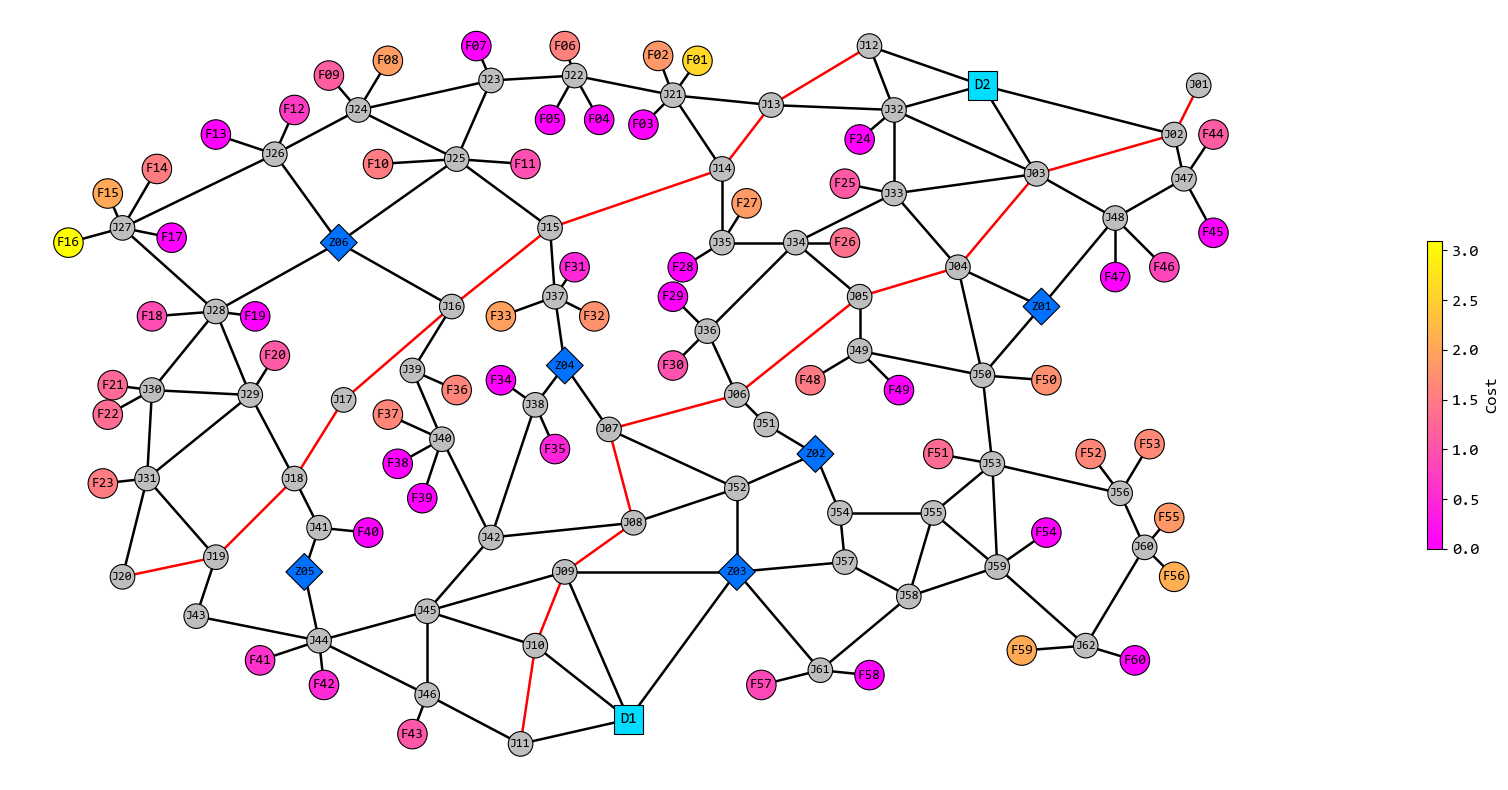

In [34]:
## 第四问道路流量计算(需要运行第三问模型建立，和第三问结果输出)

# 绘制图形
q4g = draw_graph()

q4timecost = np.zeros((nodecnts,))

for i in I:
    for j in range(len(q3path_number[i]) - 3):
        sp_ep = q3path_number[i][j+1:j+3]
        if node_number[sp_ep[0]].startswith('Z') and node_number[sp_ep[1]].startswith('F'):
            # Z-->F
            continue
            q4timecost[sp_ep[1]] += q4g.distances(sp_ep[0], sp_ep[1], weights="weight")[0][0]
        elif node_number[sp_ep[0]].startswith('F') and node_number[sp_ep[1]].startswith('Z'):
            # F-->Z
            q4timecost[sp_ep[0]] += q4g.distances(sp_ep[0], sp_ep[1], weights="weight")[0][0]      
                
# 设置点的颜色
import matplotlib.cm as cm
max_cost = max(q4timecost)
min_cost = min(q4timecost)
color_map = cm.get_cmap("spring")

for i in range(nodecnts):
    if node_number[i].startswith('F'):
        q4g.vs[i]["color"] = color_map((q4timecost[i] - min_cost) / (max_cost - min_cost))

fig4, ax4 = plt.subplots(figsize=(40, 10))

sm = cm.ScalarMappable(cmap=color_map)
sm.set_array(q4timecost)
cbar = plt.colorbar(sm, shrink=0.4, aspect=20)
cbar.set_label('Cost')

ig.plot(q4g, target=ax4, layout=q4g.layout_auto(), edge_width=1.8, vertex_frame_width=0.8)
plt.savefig('Q4flow.png', dpi=300, bbox_inches='tight', format='png')
plt.show()

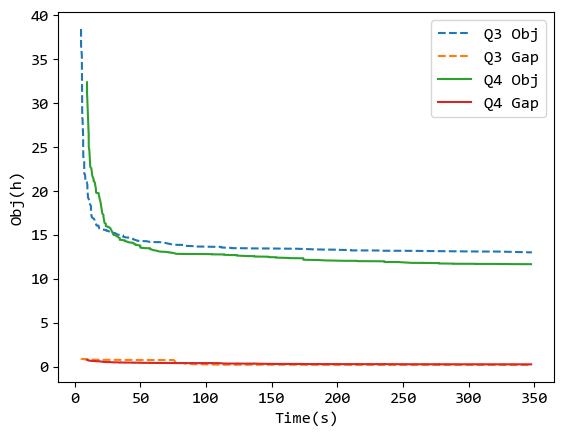

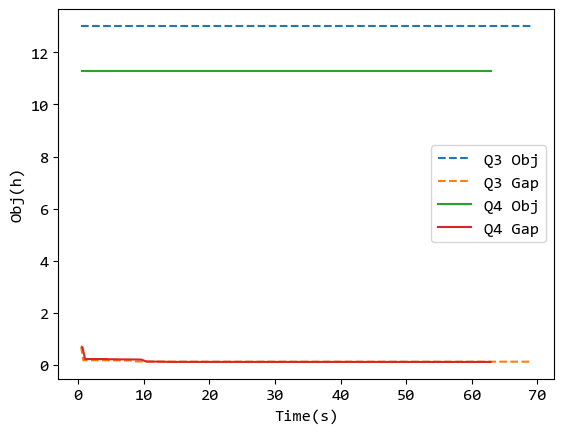

In [44]:
def read_report(filepath, style1, label1, style2, label2):
    # 存储数据的列表
    timestamps1 = []
    obj_values1 = []
    objbnd_values1 = []
    gap_values1 = []

    # 读取txt文件
    with open(filepath, 'r') as file:
        for line in file:
            # 分割每行的数据
            parts = line.split('---')
            timestamp = float(parts[0].strip())
            data_parts = parts[1].split()
            obj_value = float(data_parts[1])
            objbnd_value = float(data_parts[3])
            gap_value = float(data_parts[5])

            # 将数据添加到相应的列表中
            timestamps1.append(timestamp)
            obj_values1.append(obj_value)
            objbnd_values1.append(objbnd_value)
            gap_values1.append(gap_value)
            
    # 绘制图形
    plt.plot(timestamps1, obj_values1,style1, label=label1)
    #plt.plot(timestamps1, objbnd_values1,'-', label='ObjLowerBound')
    plt.plot(timestamps1, gap_values1,style2, label=label2)
    plt.xlabel('Time(s)')
    plt.ylabel('Obj(h)')
    plt.legend()

plt.figure()
read_report('./Q3solve/Q3report1-启发.txt','--','Q3 Obj','--','Q3 Gap')
read_report('./Q4solve/report1.txt','-','Q4 Obj','-','Q4 Gap')
plt.savefig('Q4-Q3report1.png',dpi=300)
        
plt.figure()
read_report('./Q3solve/Q3report2-分支定界.txt','--','Q3 Obj','--','Q3 Gap')
read_report('./Q4solve/report2.txt','-','Q4 Obj','-','Q4 Gap')
plt.savefig('Q4-Q3report2.png',dpi=300)